In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Tuple

In [2]:
Func = Callable[[float], float]

@dataclass
class Function:
    f: Callable[[float, float], float]
    grad: Callable[[float, float], Tuple[float, float]]
    hessian: Callable[[float, float], Tuple[Tuple[float, float], Tuple[float, float]]]

In [3]:
Rosenbrock = Function(
    f = lambda x: 100 * (x[1] - x[0] ** 2) ** 2 + (1 - x[0]) ** 2,
    grad = lambda x: np.array((
        400 * x[0] * (x[0] ** 2 - x[1]) + 2 * (x[0] - 1),
        200 * (x[1] - x[0] ** 2),
    )),
    hessian = lambda x: np.array((
        (
            400 * (3 * x[0] ** 2 - x[1]) + 2,
            -400 * x[0],
        ),
        (
            -400 * x[0],
            200,
        ),
    ))
)

In [4]:
def optimal_by_golden_ratio(f, x_k, d_k):
    golden_ratio = (1 + 5 ** .5) / 2
    a_min, a_max = 0, 1

    while a_max - a_min > 1e-5:
        part = (a_max - a_min) / golden_ratio
        a_1 = a_min + part
        a_2 = a_max - part

        f_a_1 = f(x_k + a_1 * d_k)
        f_a_2 = f(x_k + a_2 * d_k)

        if f_a_1 <= f_a_2:
            a_min = a_1
        else:
            a_max = a_2

    return (a_max + a_min) / 2

In [5]:
def method_GD(function, x_k, k):
    result_path = []
    
    for _ in range(k):
        d_k = -function.grad(x_k)
        a_k = optimal_by_golden_ratio(function.f, x_k, d_k)
        x_k = x_k + a_k * d_k
        result_path.append(x_k)
    
    return result_path

In [6]:
def method_CG_FR(function, x_k, k):
    result_path = []
    
    grad = function.grad(x_k)
    d_k = -grad

    for _ in range(k):
        a_k = optimal_by_golden_ratio(function.f, x_k, d_k)
        x_k = x_k + a_k * d_k
        result_path.append(x_k)
        
        grad_new = function.grad(x_k)
        beta = (np.linalg.norm(grad_new) / np.linalg.norm(grad)) ** 2

        d_k = -grad_new + beta * d_k
        grad = grad_new
    
    return result_path

In [7]:
def method_CG_PR(function, x_k, k):
    result_path = []
    
    grad = function.grad(x_k)
    d_k = -grad

    for _ in range(k):
        a_k = optimal_by_golden_ratio(function.f, x_k, d_k)
        x_k = x_k + a_k * d_k
        result_path.append(x_k)
        
        grad_new = function.grad(x_k)
        beta = np.dot(grad_new - grad, grad_new) / np.dot(grad, grad)

        d_k = -grad_new + beta * d_k
        grad = grad_new
    
    return result_path

In [8]:
def method_DFP(function, x_k, k):
    result_path = []
    
    grad = function.grad(x_k)
    H_k = np.identity(2)

    for _ in range(k):
        d_k = -np.dot(H_k, grad)
        x_k_old = x_k
        
        a_k = optimal_by_golden_ratio(function.f, x_k, d_k)
        x_k = x_k_old + a_k * d_k
        result_path.append(x_k)
        
        grad_new = function.grad(x_k)

        delta_x_k = np.transpose(np.array((x_k - x_k_old,)))
        delta_grad = np.transpose(np.array((grad_new - grad,)))

        H_k = (
            H_k
            + np.dot(delta_x_k, np.transpose(delta_x_k))
                / np.dot(np.transpose(delta_x_k), delta_grad)[0][0]
            - np.linalg.multi_dot((H_k, delta_grad, np.transpose(delta_grad), H_k))
                / np.linalg.multi_dot((np.transpose(delta_grad), H_k, delta_grad))[0][0]
        )

        grad = grad_new
    
    return result_path

In [9]:
def method_LM(function, x_k, k):
    learning_rate = 1e-5
    result_path = []
    
    f_val = function.f(x_k)

    for _ in range(k):
        delta_x = - np.dot(
            np.linalg.inv(function.hessian(x_k)) + np.identity(2) * learning_rate,
            function.grad(x_k)
        )

        x_k = x_k + delta_x
        result_path.append(x_k)
        
        f_val_new = function.f(x_k)
        if f_val_new < f_val:
            learning_rate /= 10
        else:
            learning_rate *= 10
    
    return result_path

In [10]:
dist_to_min = lambda x: np.linalg.norm(x - np.array((1, 1)))
f_value = Rosenbrock.f

def prepare_result(result_path, prep_f):
    return zip(*enumerate(map(prep_f, result_path)))

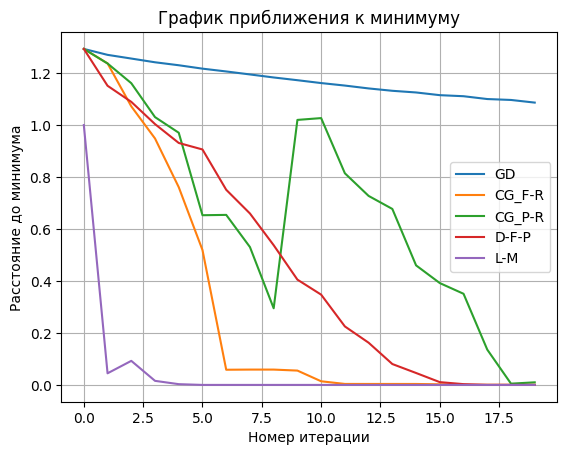

In [11]:
x_0_1 = np.array((-1.2, 1))
x_0_2 = np.array((0, 0))
x_0_3 = np.array((-2, 2))
x_0 = x_0_2
k = 20

plt.plot(*prepare_result(method_GD(Rosenbrock, x_0, k), dist_to_min), label="GD")
plt.plot(*prepare_result(method_CG_FR(Rosenbrock, x_0, k), dist_to_min), label="CG_F-R")
plt.plot(*prepare_result(method_CG_PR(Rosenbrock, x_0, k), dist_to_min), label="CG_P-R")
plt.plot(*prepare_result(method_DFP(Rosenbrock, x_0, k), dist_to_min), label="D-F-P")
plt.plot(*prepare_result(method_LM(Rosenbrock, x_0, k), dist_to_min), label="L-M")

plt.title("График приближения к минимуму")
plt.xlabel("Номер итерации")
plt.ylabel("Расстояние до минимума")
plt.grid(True)
plt.legend()
plt.show()

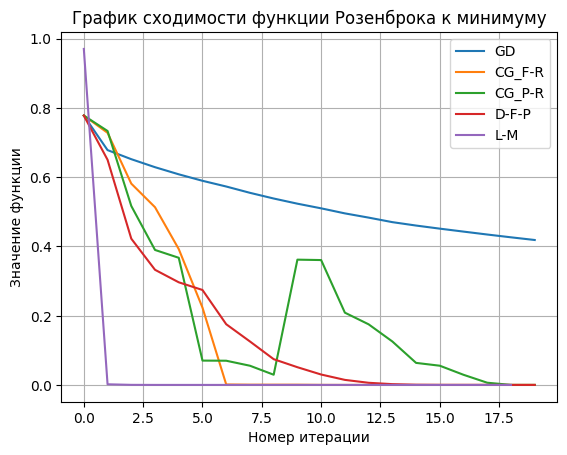

In [12]:
plt.plot(*prepare_result(method_GD(Rosenbrock, x_0, k), f_value), label="GD")
plt.plot(*prepare_result(method_CG_FR(Rosenbrock, x_0, k), f_value), label="CG_F-R")
plt.plot(*prepare_result(method_CG_PR(Rosenbrock, x_0, k), f_value), label="CG_P-R")
plt.plot(*prepare_result(method_DFP(Rosenbrock, x_0, k), f_value), label="D-F-P")
plt.plot(*prepare_result(method_LM(Rosenbrock, x_0, k)[1:], f_value), label="L-M")

plt.title("График сходимости функции Розенброка к минимуму")
plt.xlabel("Номер итерации")
plt.ylabel("Значение функции")
plt.grid(True)
plt.legend()
plt.show()